## Kalashnik 1994


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {'save_figs':       False,
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
}

### OPEN DATA
dsg = xr.open_dataset(PRMS['ds_glob_path'])
print('Nb of storms: {}'.format(len(dsg.time)))

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

Nb of storms: 335


In [3]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 195


In [4]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

In [5]:
# plt.hist(np.log(abs(dsg.dKdt_IBT)), bins=50)

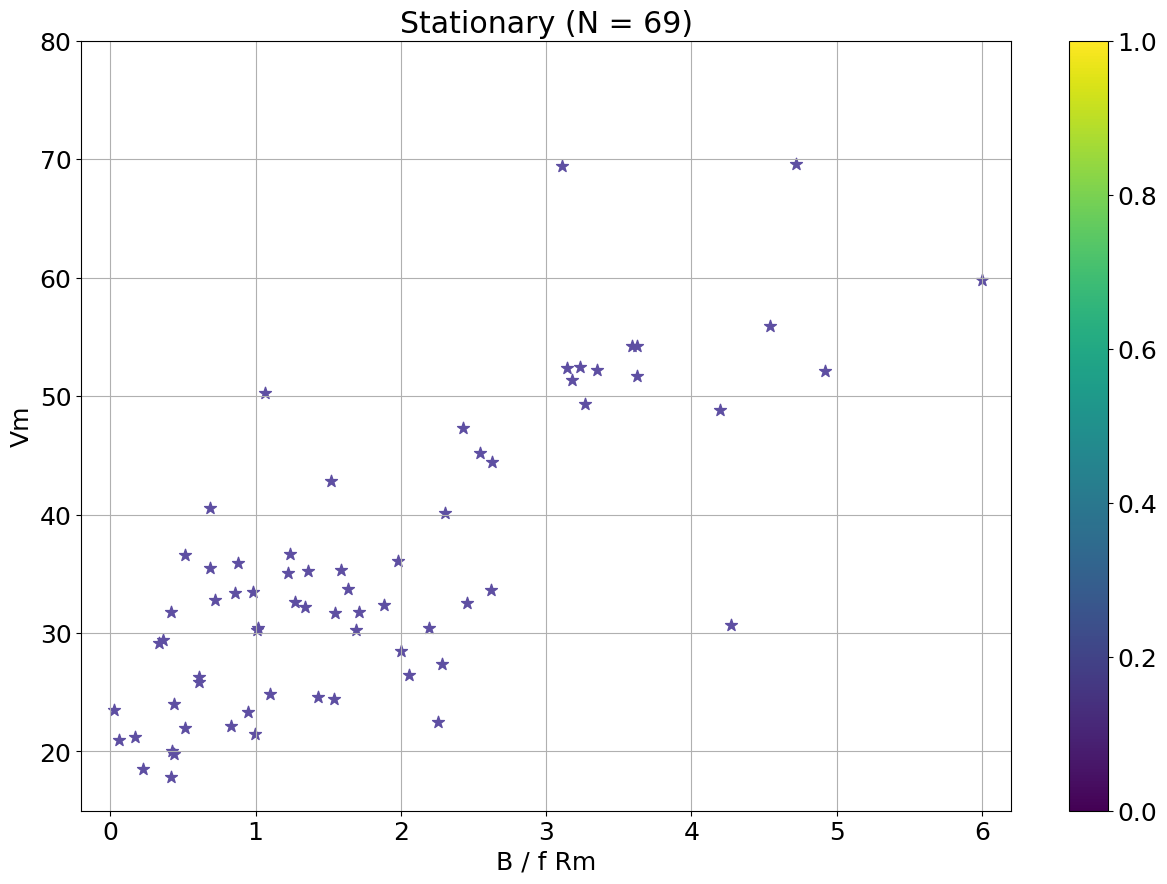

In [6]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

cmap = cm.get_cmap('Spectral_r')

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)
plt.colorbar()

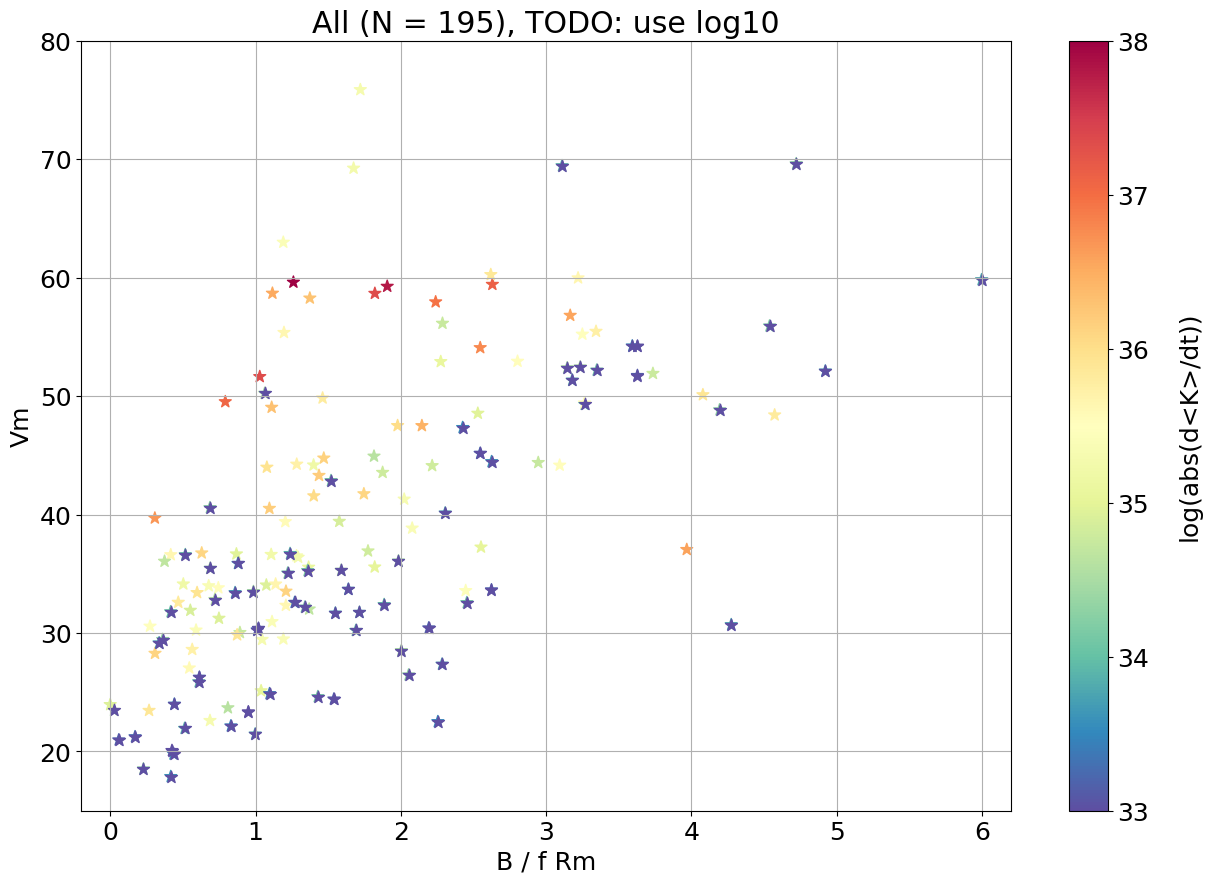

In [7]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

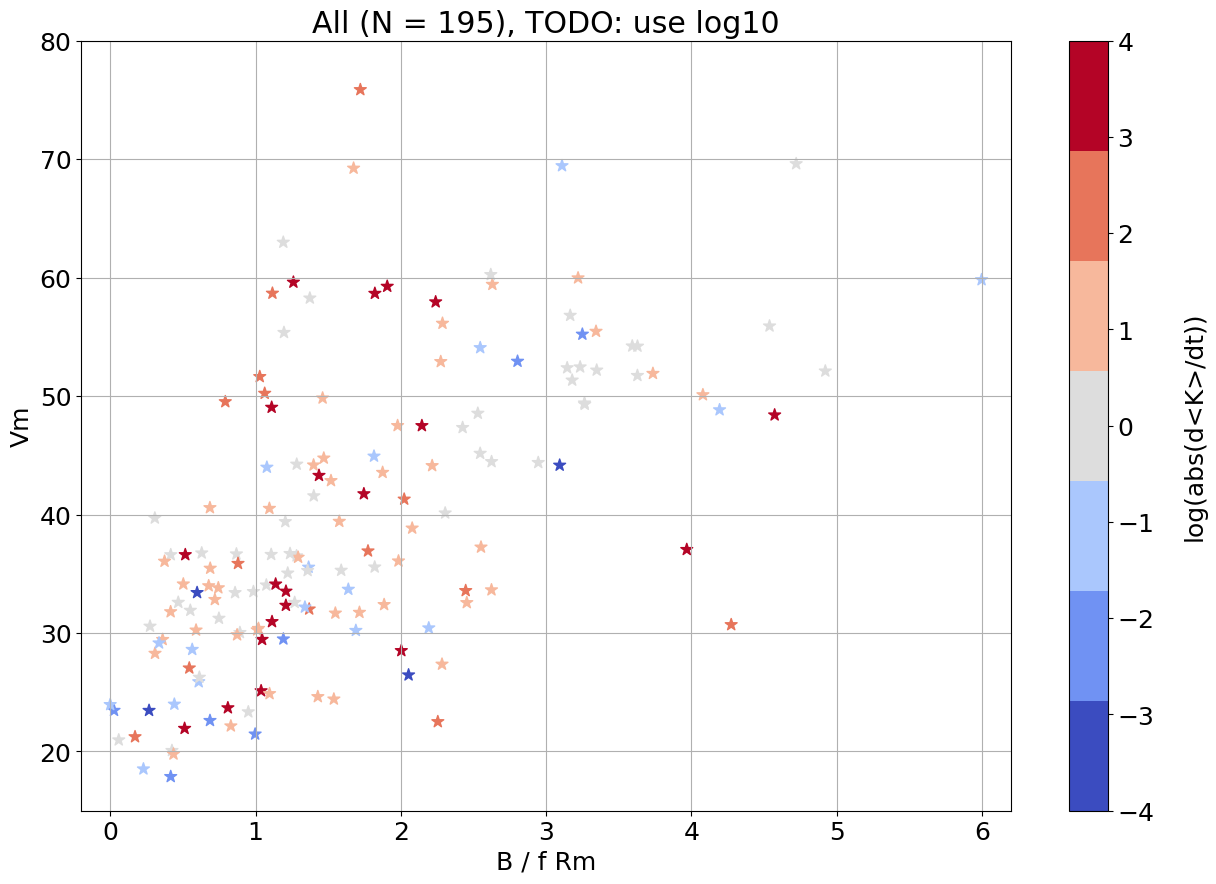

In [8]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 7)

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=d2.R17_dot_smth_IBT, vmin=-4, vmax=4, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color='k')

In [9]:
# ratio = K1_SAR / K2_SAR
# plt.hist(ratio[np.isfinite(ratio)], bins=100)
# plt.xlim(-10, 10)

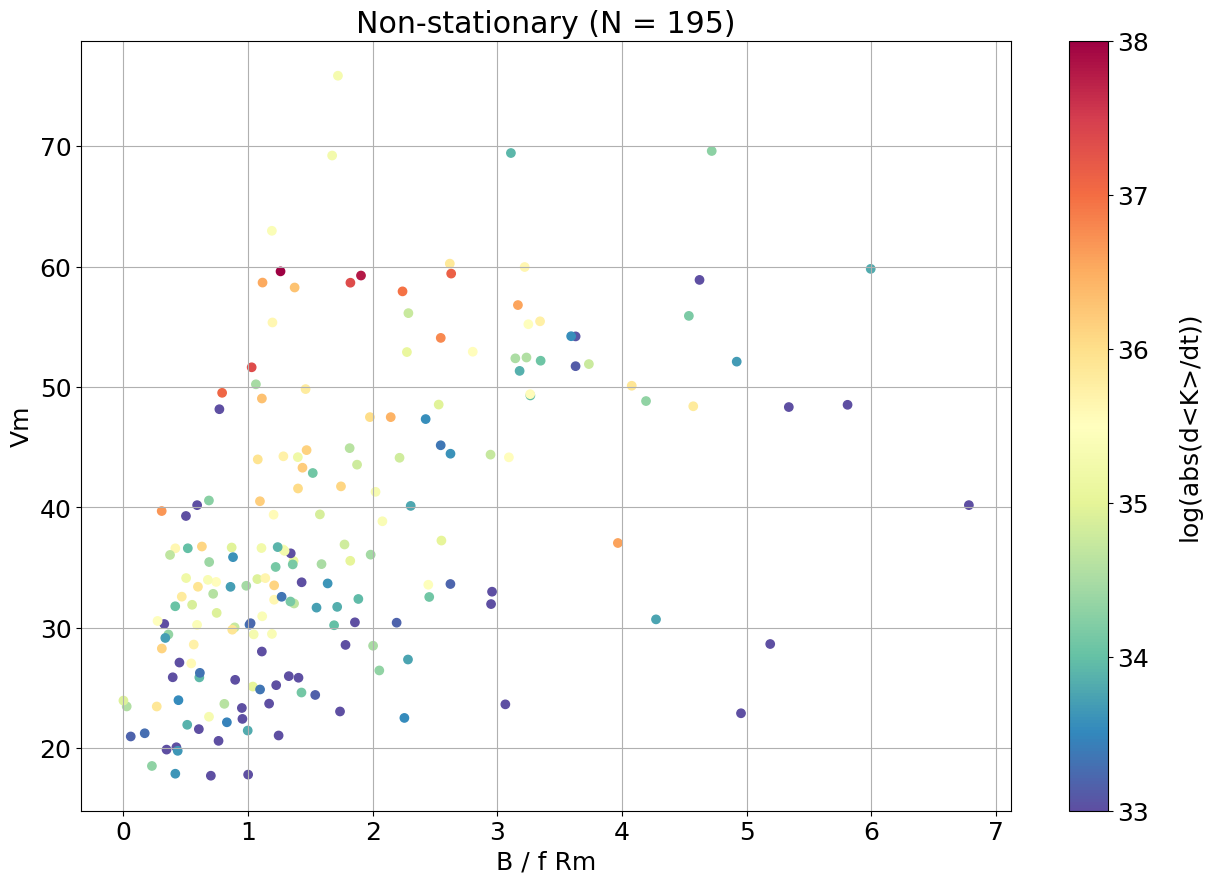

In [10]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=np.log(abs(dsg.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

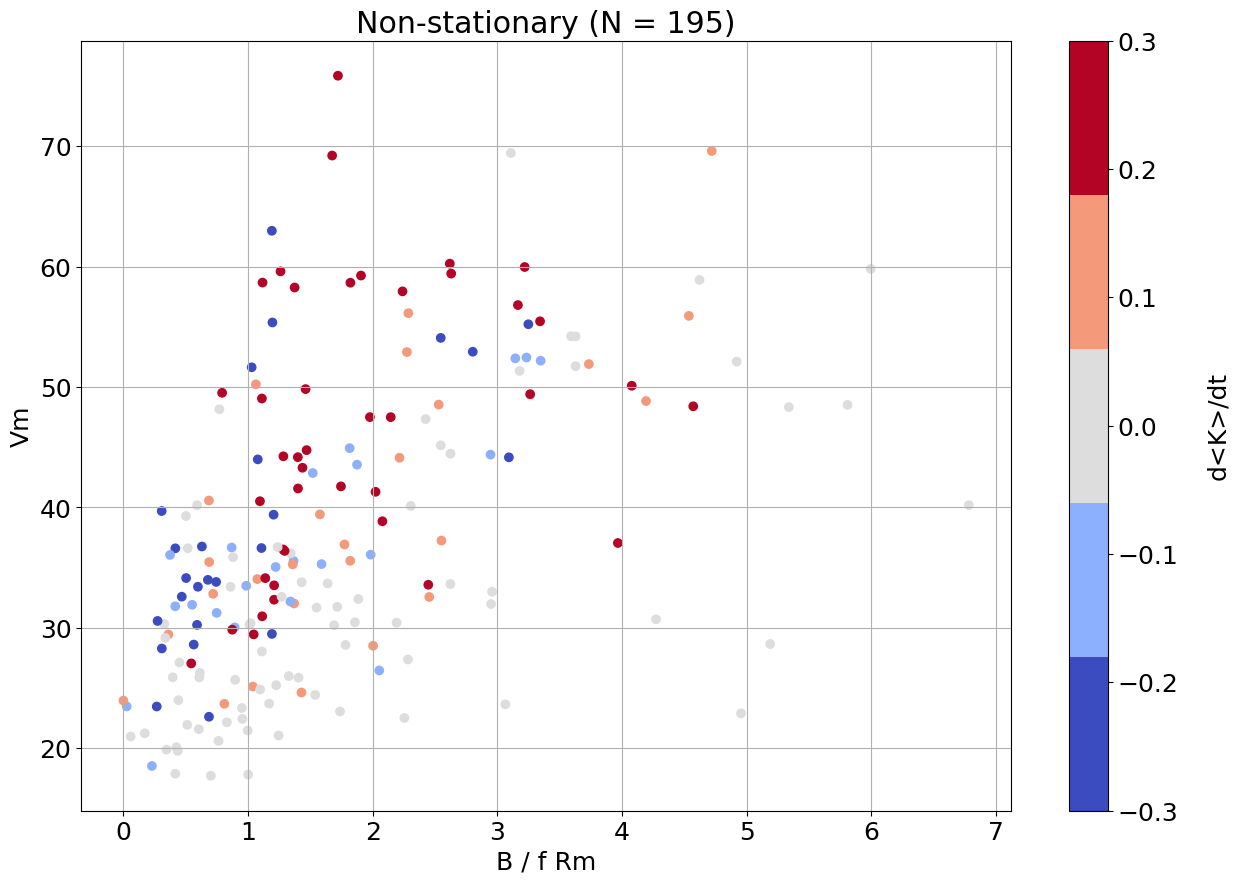

In [11]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dsg.dKdt_SAR / 1e16, vmin=-0.3, vmax=0.3, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

### Test by considering H = Vm^2 constant in time

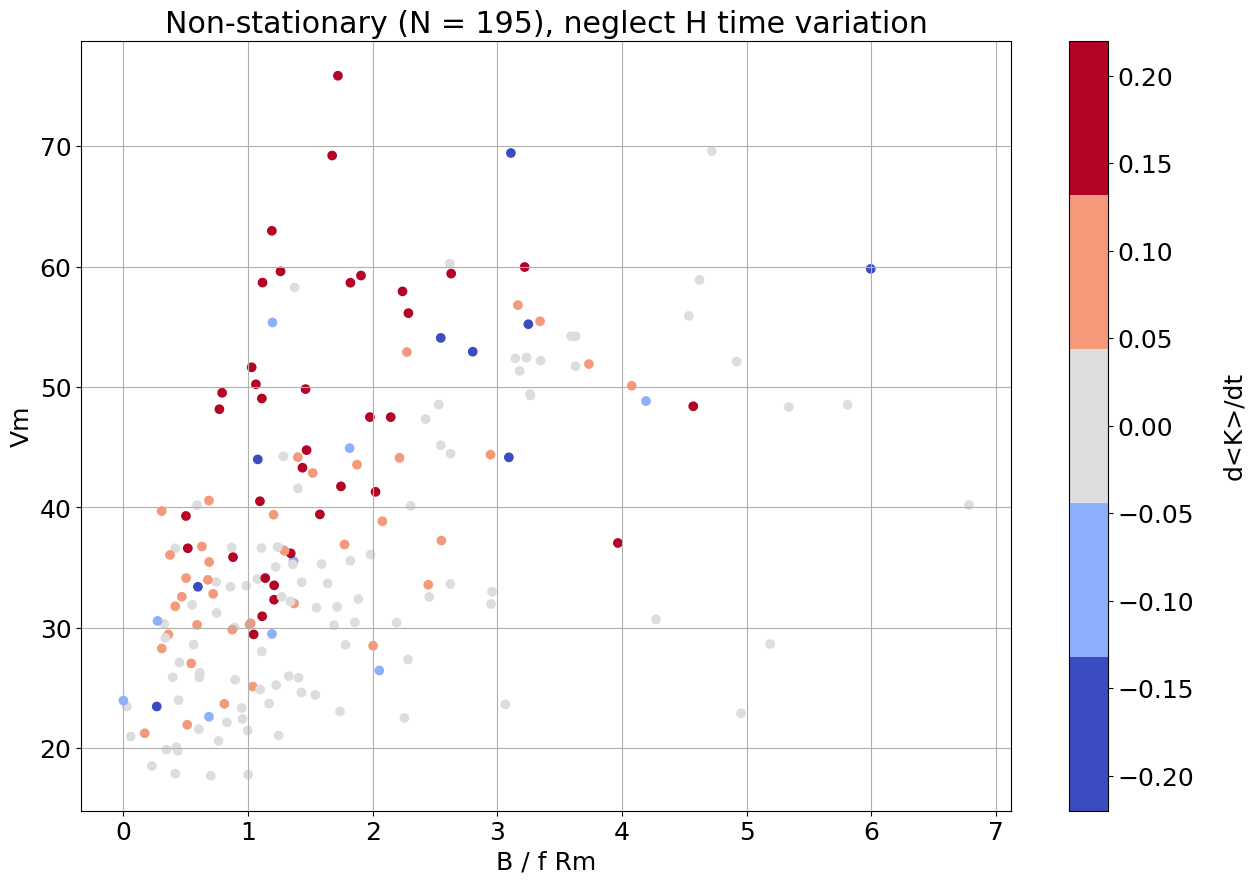

In [12]:
dK_dt = (dsg['Vmax_1D'] ** 2) * dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) 
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect H time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

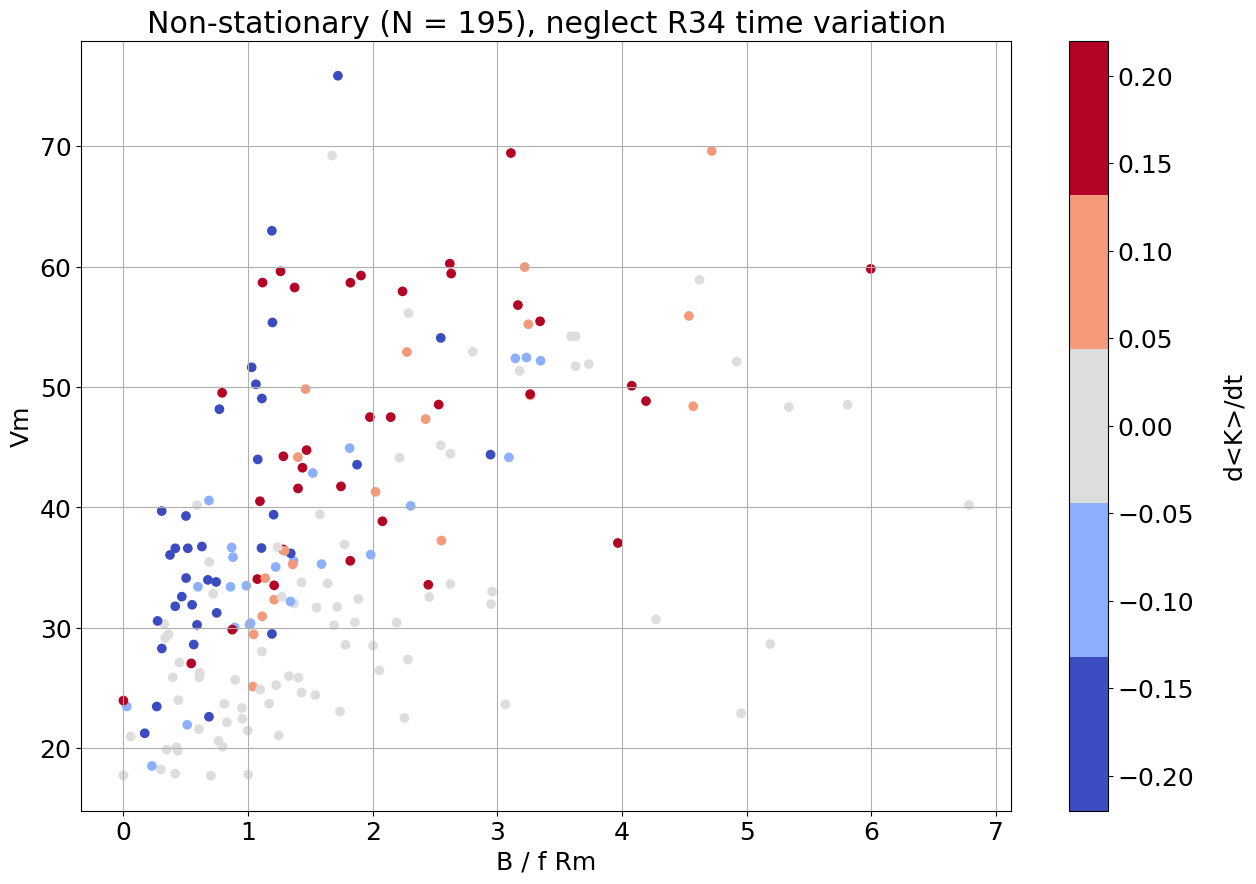

In [13]:
dK_dt = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect R34 time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

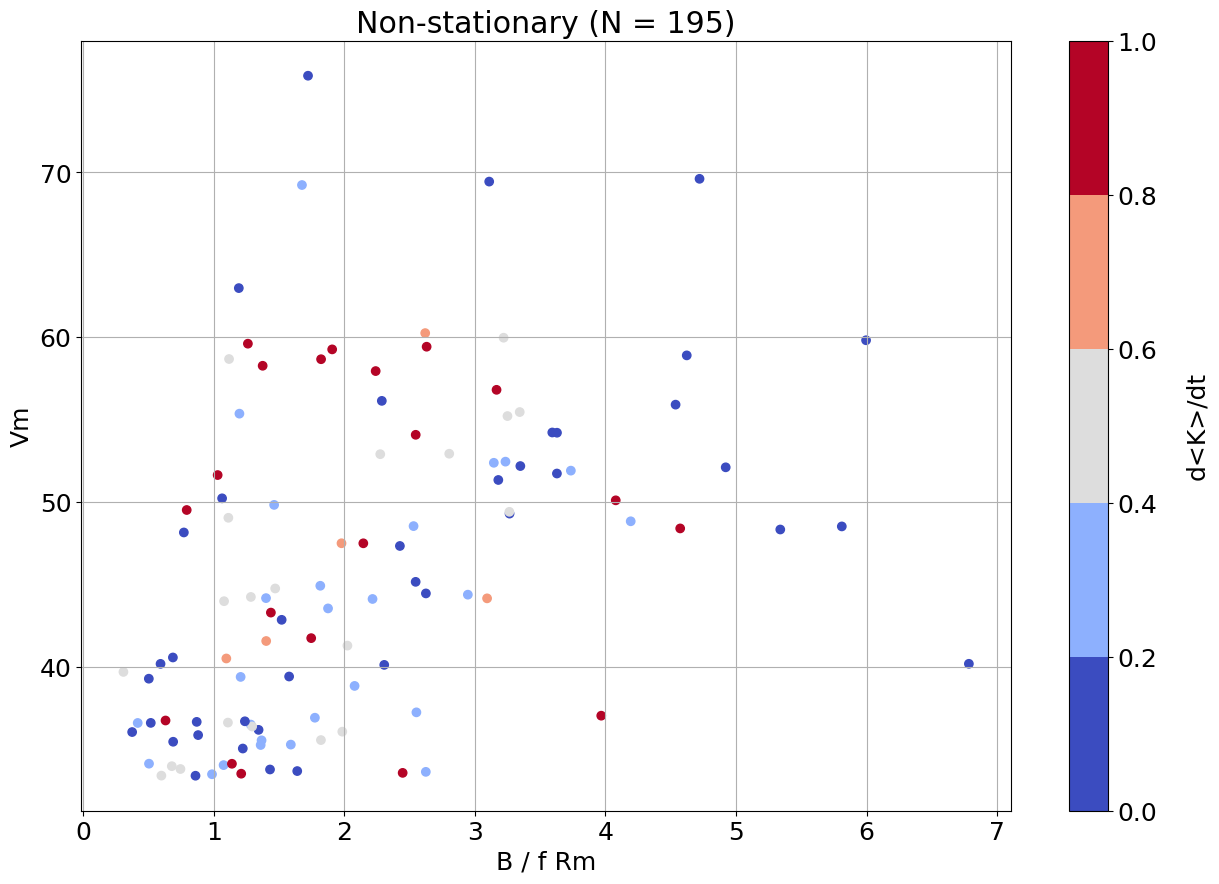

In [14]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=abs(dsg.dKdt_SAR / (dsg.R33_1D * 1000 * 33 ** 2)) / 1e8, vmin=0, vmax=1, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [15]:
d1 = dsg.where(dsg.sat_file == 'rs2--owi-cm-20210421t094352-20210421t094508-00003-F7A21_sw.nc', drop=True).isel(time=0)
d2 = dsg.where(dsg.sat_file == 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc', drop=True).isel(time=0)

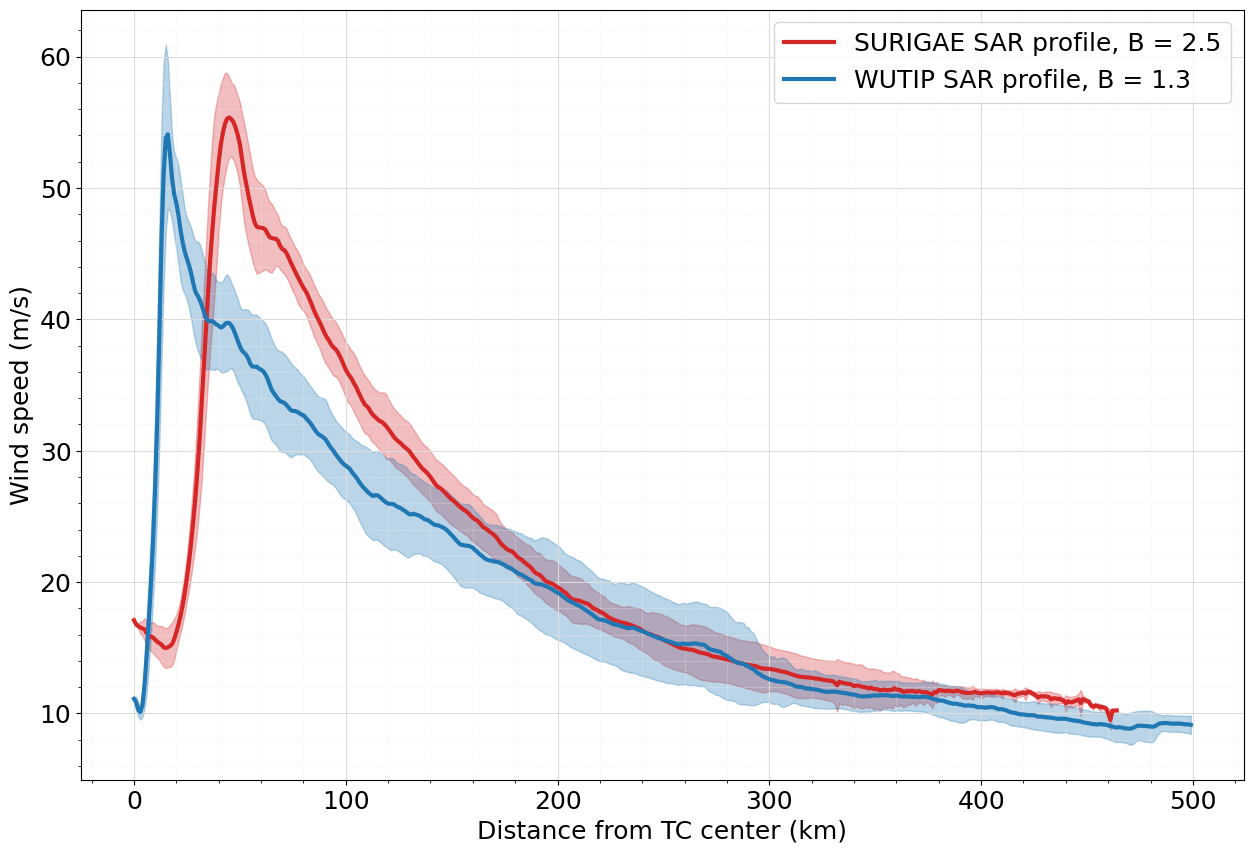

In [16]:
# SAR profiles
ws1 = d1.wind_speed.mean(dim='theta', skipna=True)
st1 = d1.wind_speed.std(dim='theta', skipna=True)
ws2 = d2.wind_speed.mean(dim='theta', skipna=True)
st2 = d2.wind_speed.std(dim='theta', skipna=True)
plt.plot(ws1.rad / 1000, ws1, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.fill_between(ws1.rad / 1000, ws1 - st1, ws1 + st1, color='tab:red', alpha=0.3)
plt.plot(ws2.rad / 1000, ws2, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')
plt.fill_between(ws2.rad / 1000, ws2 - st2, ws2 + st2, color='tab:blue', alpha=0.3)

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='upper right', frameon=True)

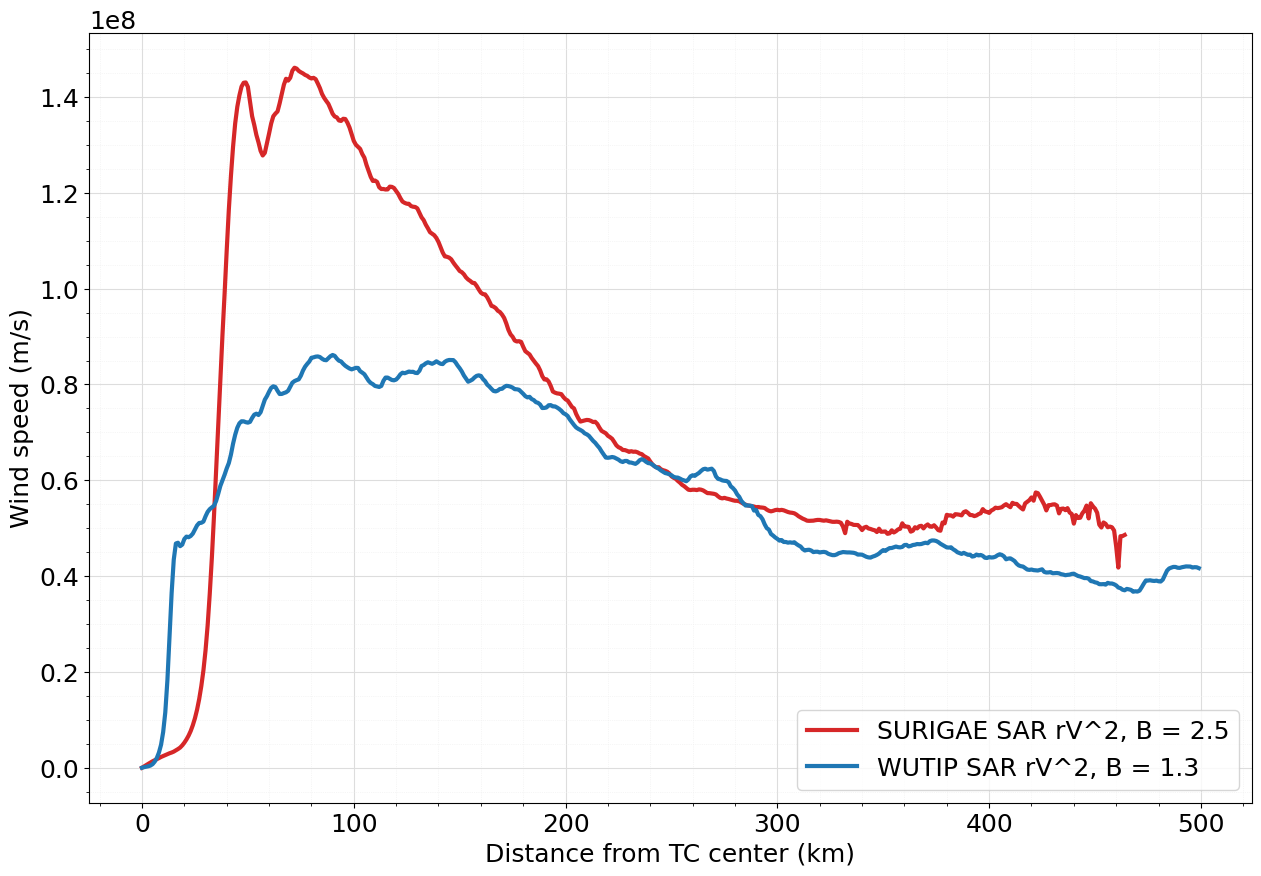

In [17]:
# SAR profiles
plt.plot(ws1.rad / 1000, ws1.rad * (ws1 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.plot(ws2.rad / 1000, ws2.rad * (ws2 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='lower right', frameon=True)

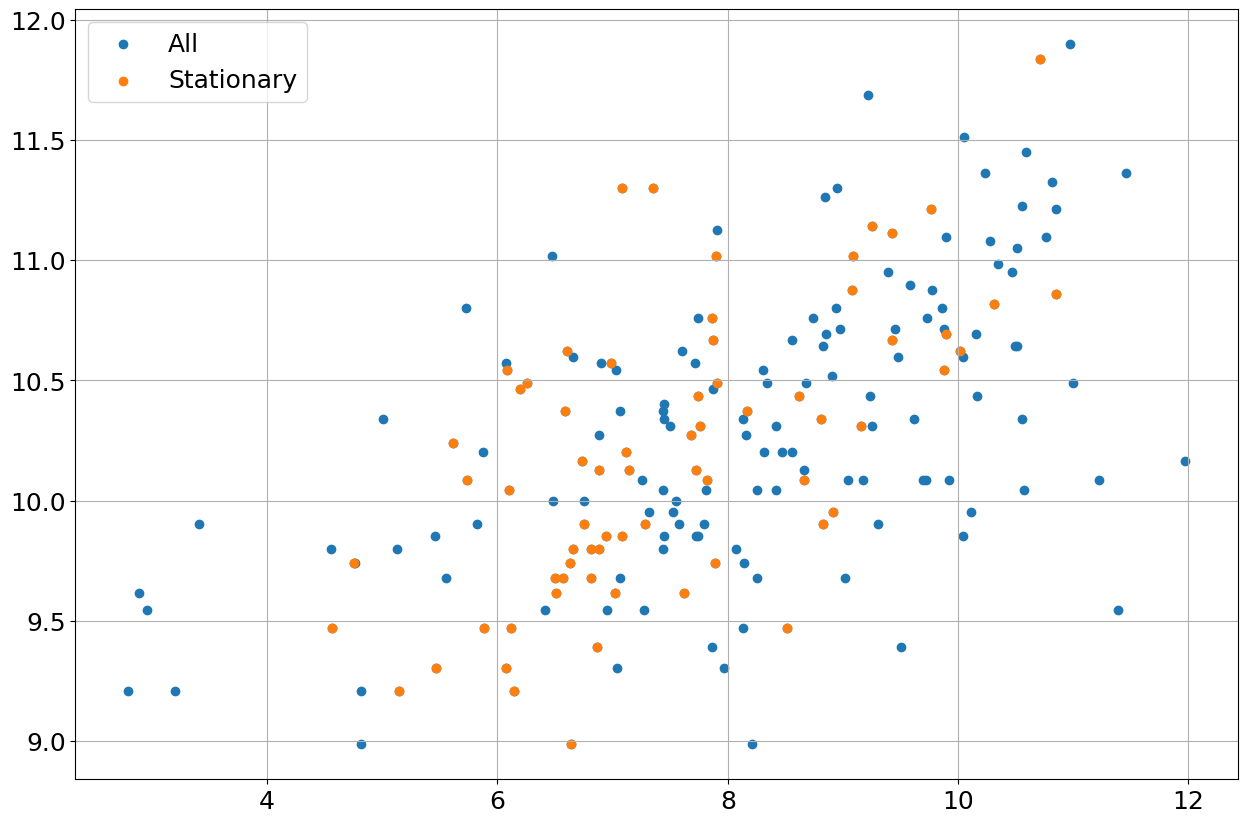

In [18]:
x     = ((dsg.R17_1D * 1000) ** 3) * ((abs(coriolis(dsg.lat_center))) ** 2) / (4 * 17.5 ** 2)
y     = dsg.Rmax_1D * 1000

x_stt = ((d.R17_1D * 1000) ** 3) * ((abs(coriolis(d.lat_center))) ** 2) / (4 * 17.5 ** 2)
y_stt = d.Rmax_1D * 1000

plt.scatter(np.log(x), np.log(y), label='All')
plt.scatter(np.log(x_stt), np.log(y_stt), label='Stationary')
plt.grid()
plt.legend()

Text(0, 0.5, 'Vm^2')

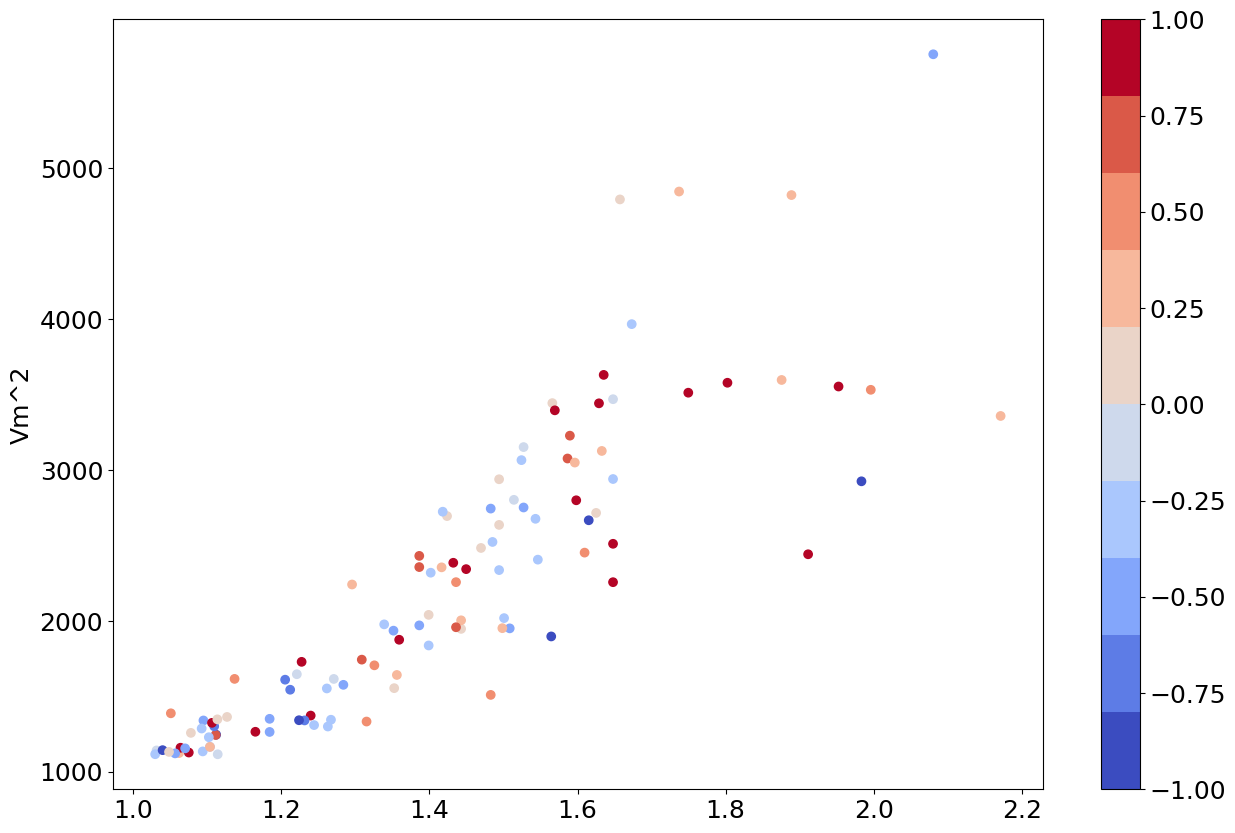

In [19]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

Text(0, 0.5, 'Vm^2')

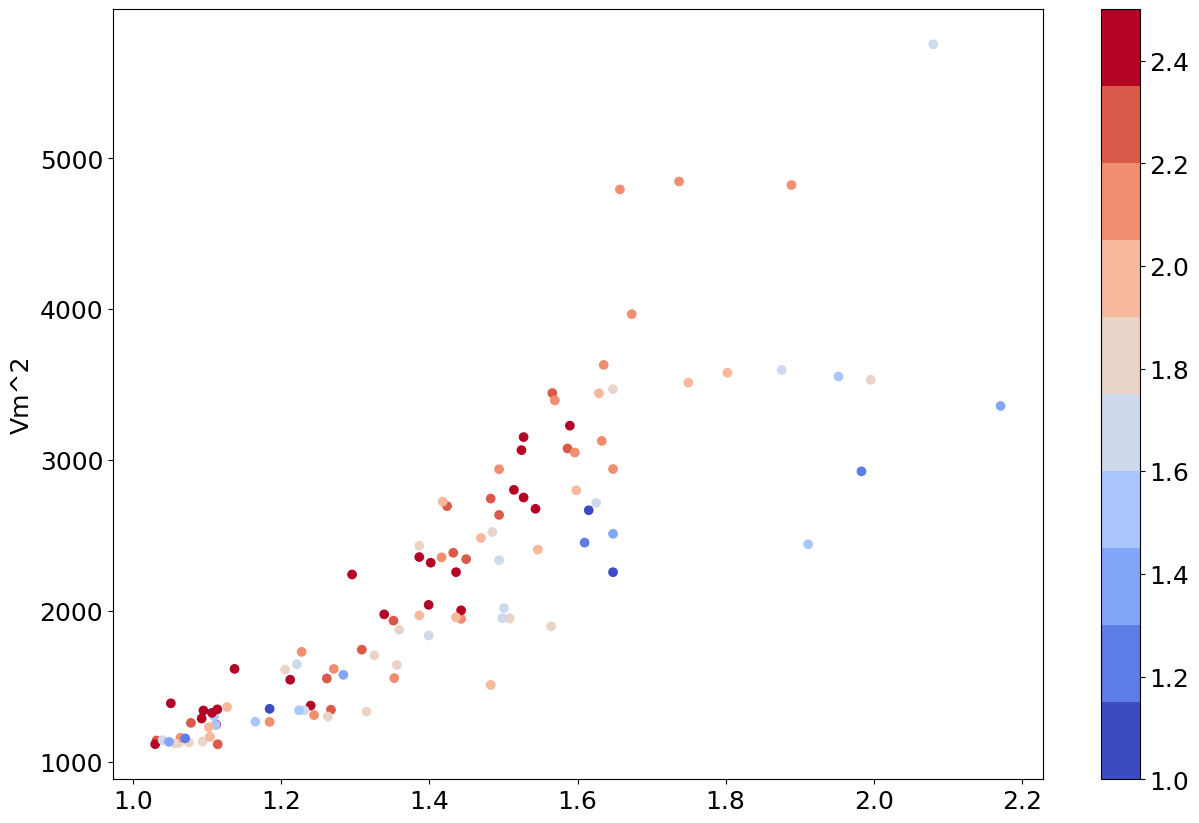

In [20]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

Text(0, 0.5, 'Vm^2')

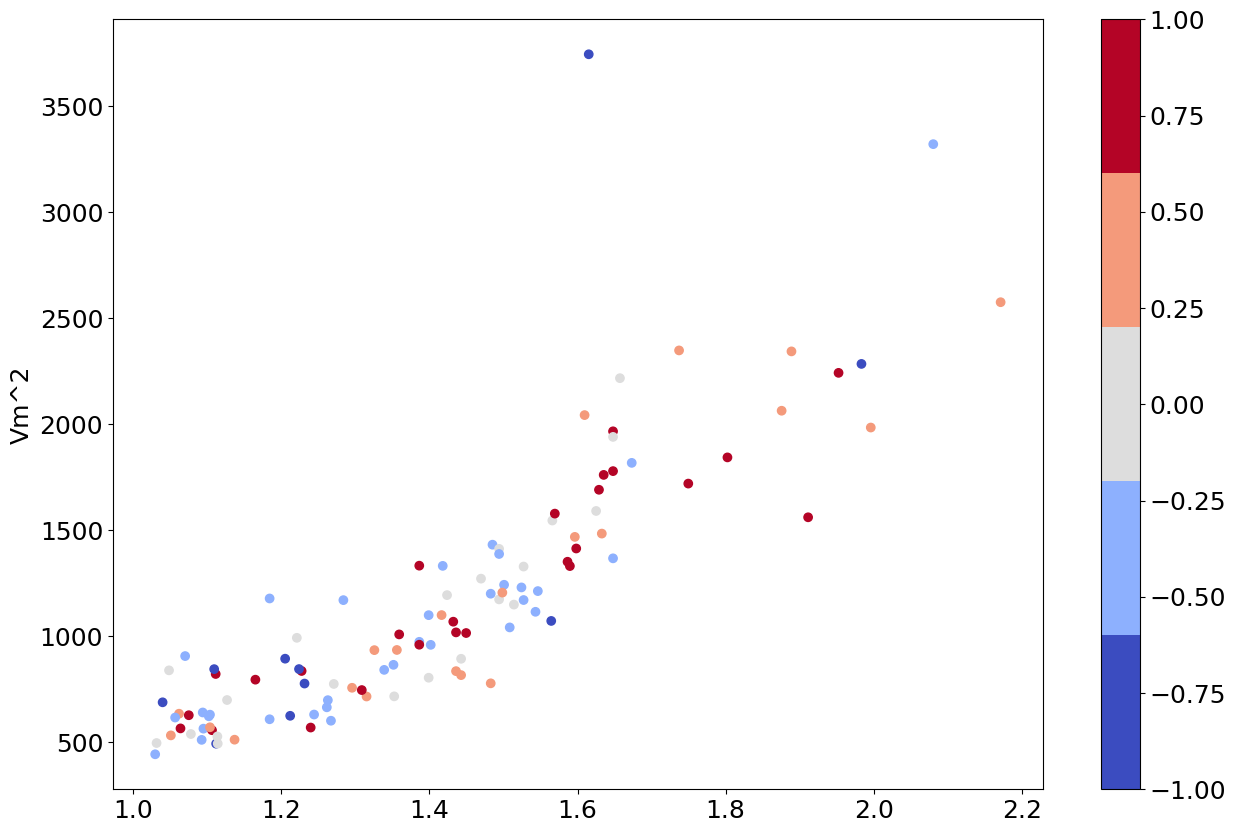

In [21]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), (1 / dsg.B_hol) * dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

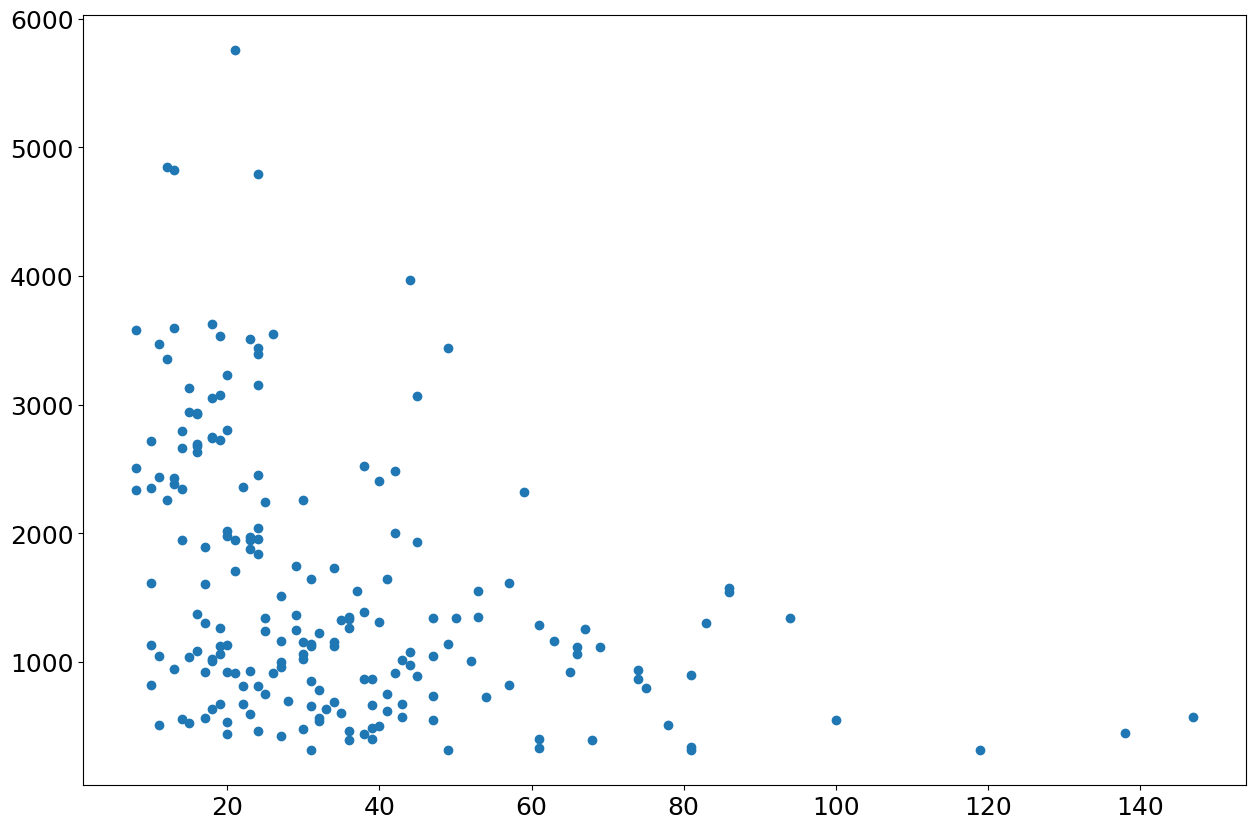

In [22]:
plt.scatter(dsg.Rmax_1D, dsg.Vmax_1D ** 2)

Text(0, 0.5, 'Vm^2')

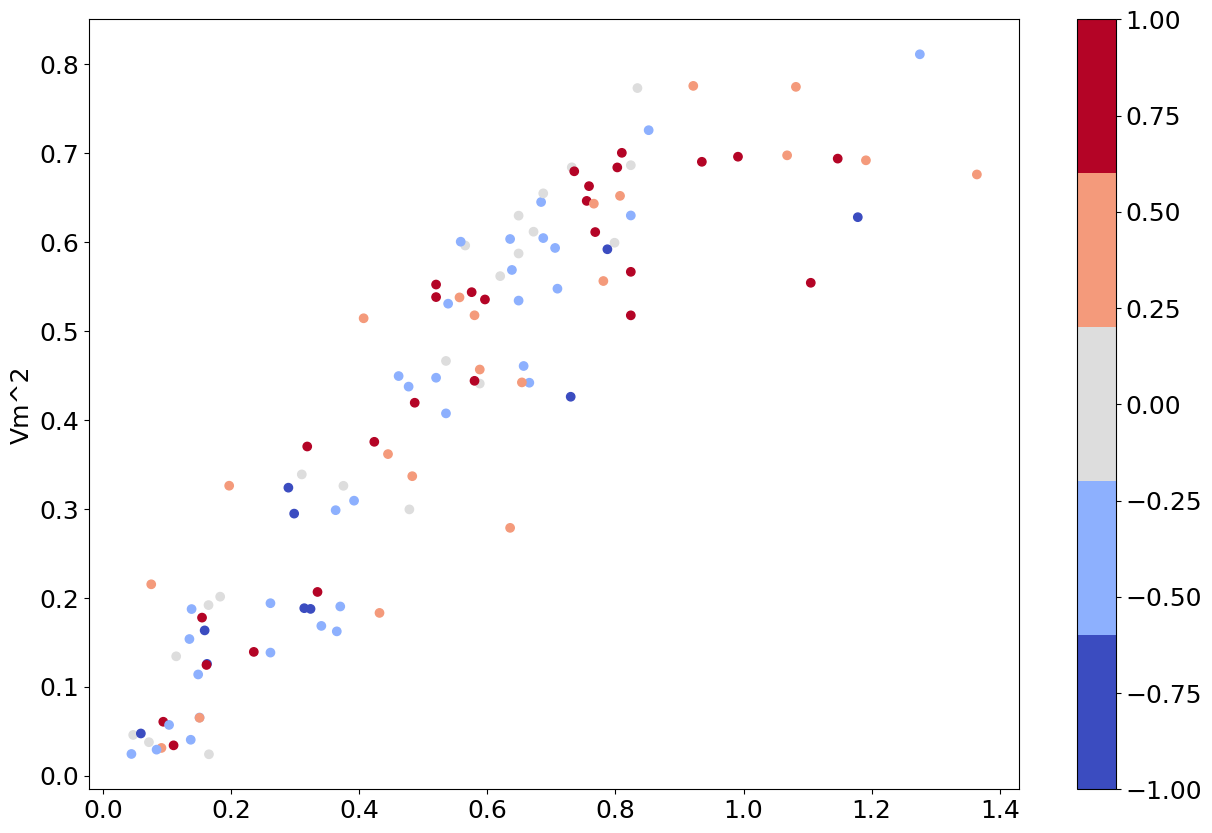

In [23]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

Text(0, 0.5, 'Vm^2')

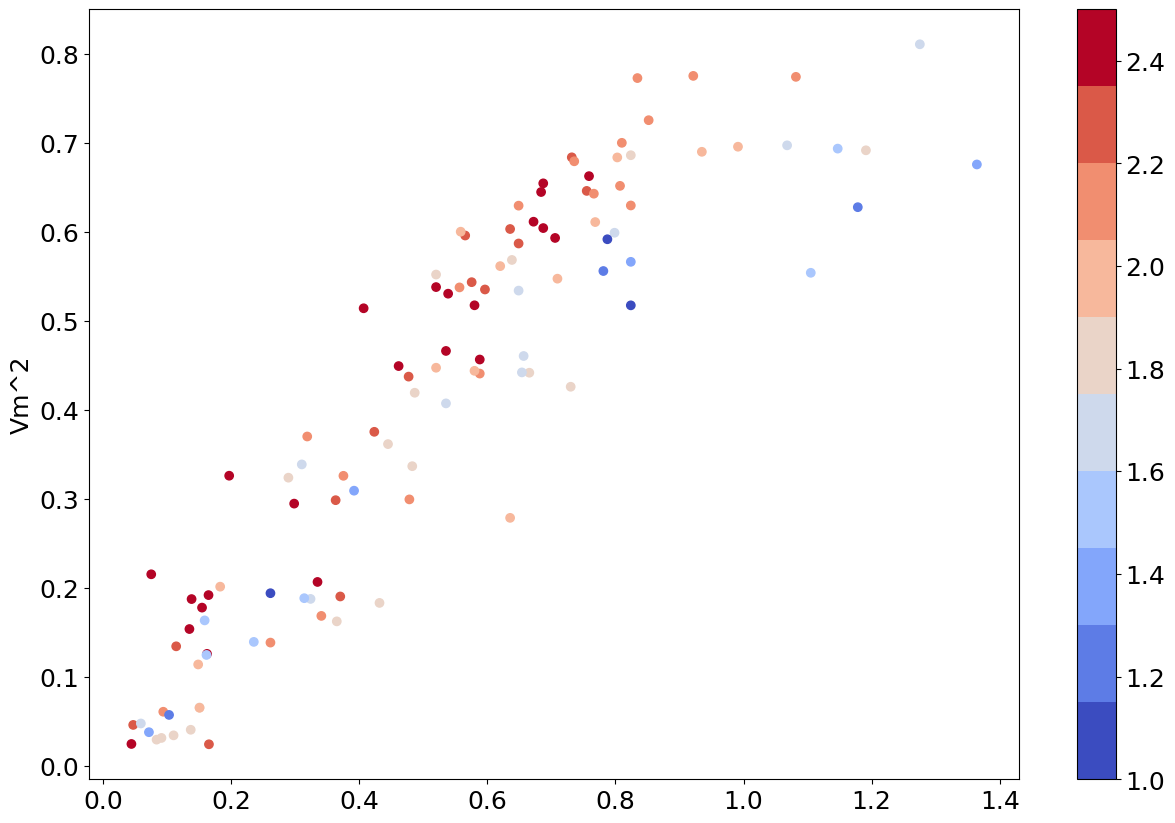

In [24]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

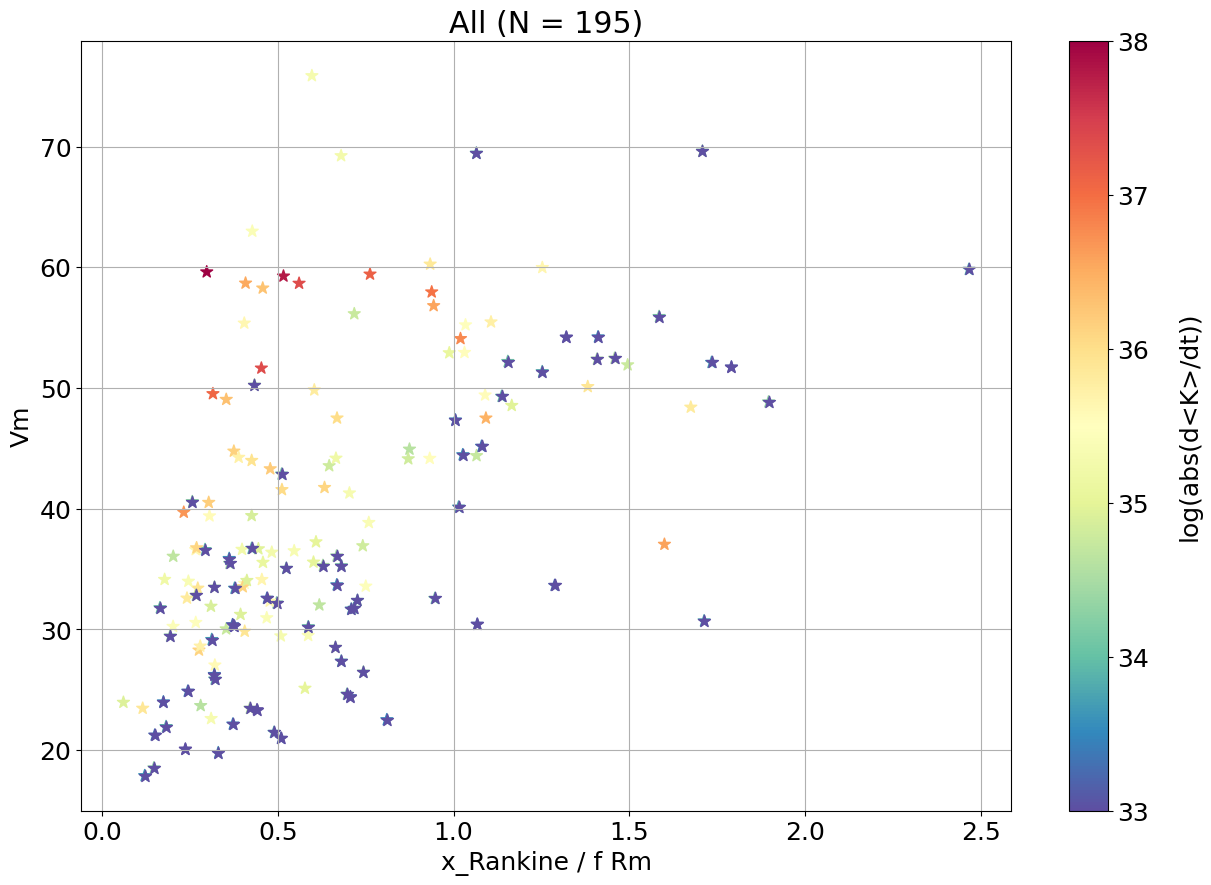

In [25]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {})'.format(len(dsg.time)))
# plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)
plt.scatter(d2.x_rkn / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('x_Rankine / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.001, 0.06)
# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.x_rkn / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

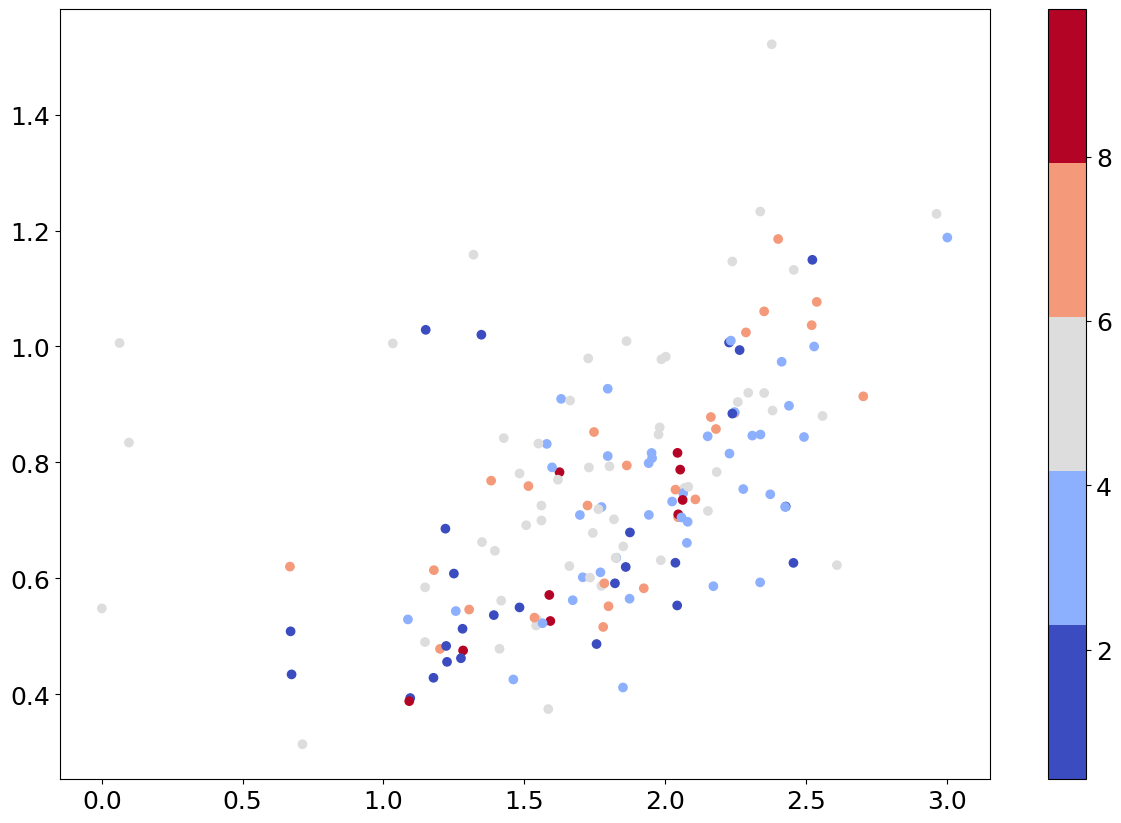

In [26]:
plt.scatter(d2.B_hol, d2.x_rkn, c=d2.cyclone_speed, cmap=cm.get_cmap('coolwarm', 5));plt.colorbar()

(array([ 3.,  0.,  4., 10., 21., 38., 37., 29., 13.,  3.]),
 array([8.76150784e-10, 3.00283929e-01, 6.00567858e-01, 9.00851787e-01,
        1.20113572e+00, 1.50141964e+00, 1.80170357e+00, 2.10198750e+00,
        2.40227143e+00, 2.70255536e+00, 3.00283929e+00]),
 <BarContainer object of 10 artists>)

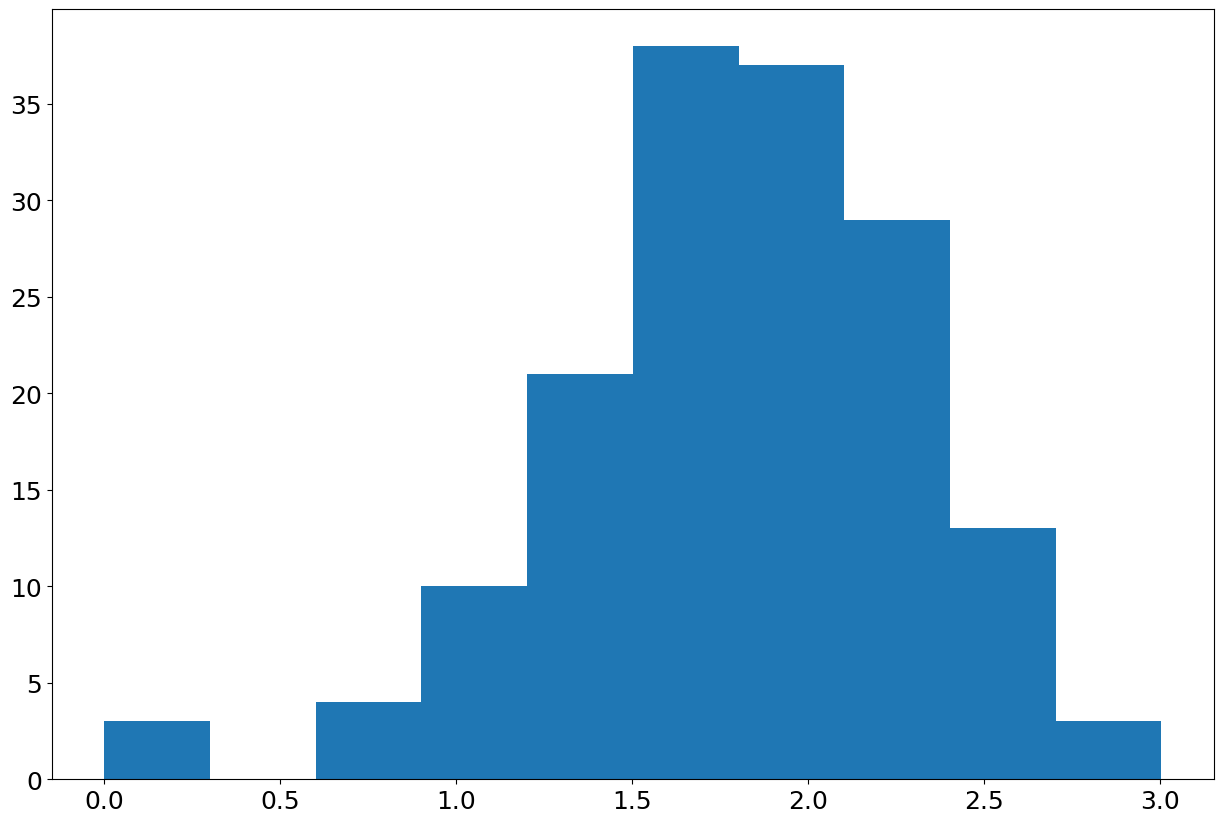

In [27]:
plt.hist(d2.B_hol)

(array([ 1.,  0.,  1.,  2.,  4.,  1.,  4.,  3.,  8.,  8.,  4.,  9.,  9.,
         4.,  3.,  6., 11.,  7.,  7.,  8.,  6.,  5.,  7.,  6.,  5.,  3.,
         0.,  4.,  7.,  4.,  1.,  1.,  0.,  1.,  3.,  0.,  2.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.31377017, 0.33792074, 0.36207132, 0.38622189, 0.41037247,
        0.43452304, 0.45867362, 0.4828242 , 0.50697477, 0.53112535,
        0.55527592, 0.5794265 , 0.60357707, 0.62772765, 0.65187823,
        0.6760288 , 0.70017938, 0.72432995, 0.74848053, 0.7726311 ,
        0.79678168, 0.82093226, 0.84508283, 0.86923341, 0.89338398,
        0.91753456, 0.94168513, 0.96583571, 0.98998629, 1.01413686,
        1.03828744, 1.06243801, 1.08658859, 1.11073916, 1.13488974,
        1.15904032, 1.18319089, 1.20734147, 1.23149204, 1.25564262,
        1.27979319, 1.30394377, 1.32809435, 1.35224492, 1.3763955 ,
        1.40054607, 1.42469665, 1.44884723, 1.4729978 , 1.49714838,
        1.52129895]),
 <BarContainer

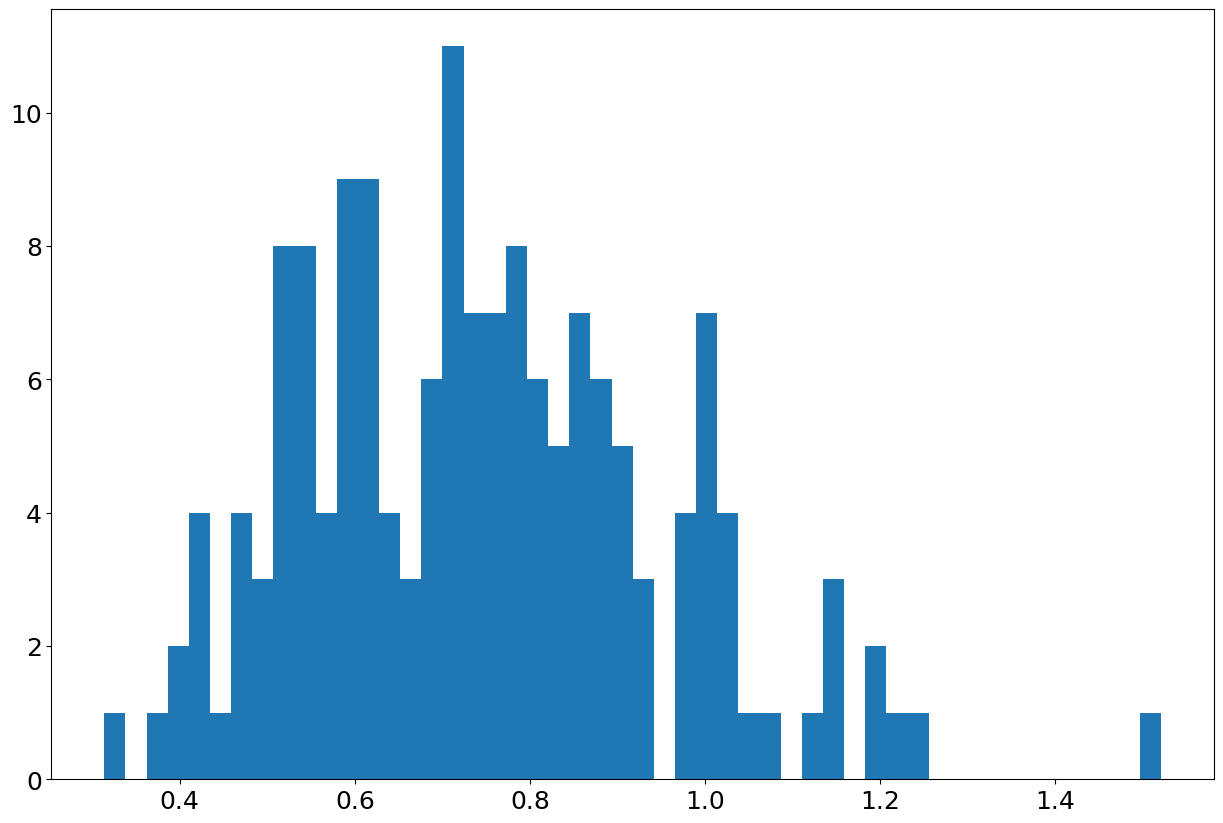

In [28]:
plt.hist(d2.x_rkn, bins=50)

(array([1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 1., 2., 1., 3., 2., 2., 3.,
        5., 1., 1., 0., 3., 3., 4., 4., 2., 3., 1., 1., 5., 1., 3., 2., 1.,
        0., 0., 0., 0., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.]),
 array([0.31377017, 0.33206999, 0.35036982, 0.36866965, 0.38696948,
        0.40526931, 0.42356914, 0.44186897, 0.4601688 , 0.47846863,
        0.49676846, 0.51506828, 0.53336811, 0.55166794, 0.56996777,
        0.5882676 , 0.60656743, 0.62486726, 0.64316709, 0.66146692,
        0.67976674, 0.69806657, 0.7163664 , 0.73466623, 0.75296606,
        0.77126589, 0.78956572, 0.80786555, 0.82616538, 0.84446521,
        0.86276503, 0.88106486, 0.89936469, 0.91766452, 0.93596435,
        0.95426418, 0.97256401, 0.99086384, 1.00916367, 1.0274635 ,
        1.04576332, 1.06406315, 1.08236298, 1.10066281, 1.11896264,
        1.13726247, 1.1555623 , 1.17386213, 1.19216196, 1.21046179,
        1.22876161]),
 <BarContainer object of 50 artists>)

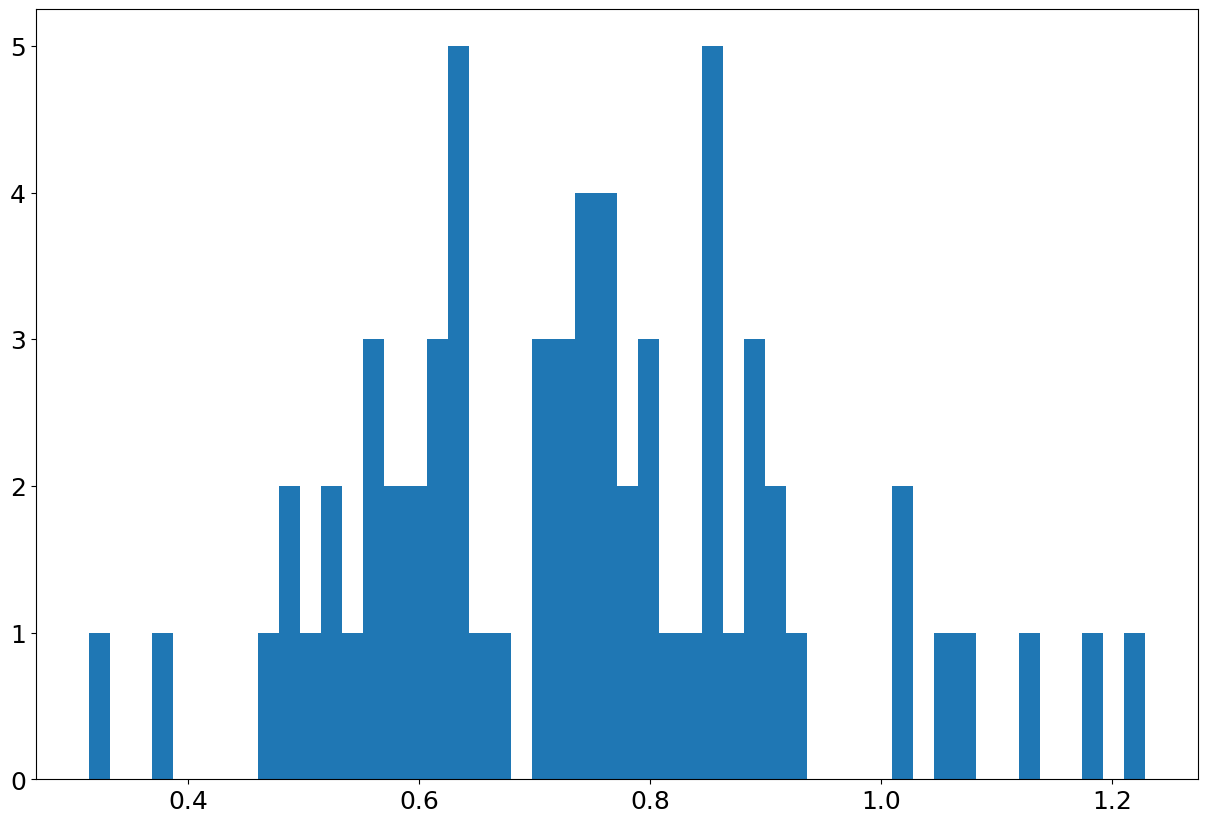

In [29]:
plt.hist(d2.where(d2.Vmax_1D > 40, drop=True).x_rkn, bins=50)

Text(0.5, 1.0, 'colored by storm speed')

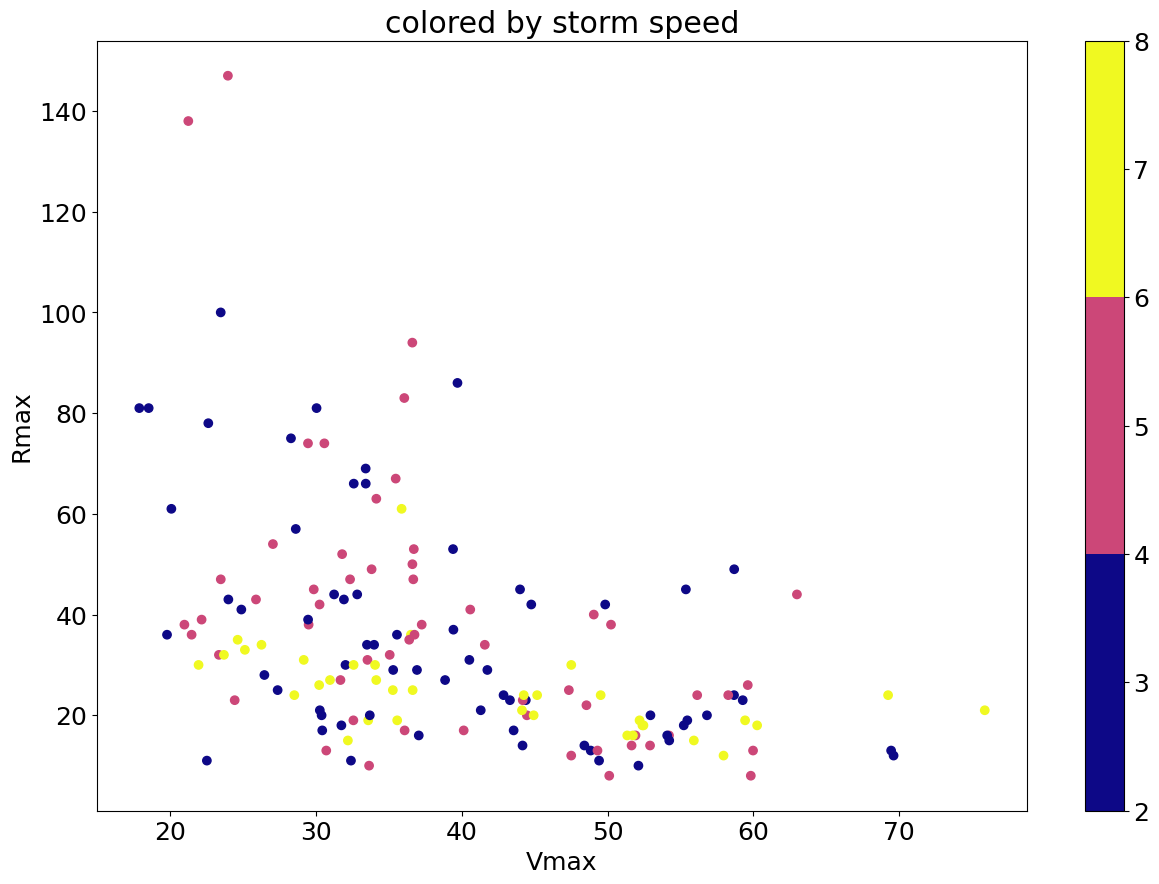

In [30]:
plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.cyclone_speed, cmap=cm.get_cmap('plasma', 3), vmin=2, vmax=8);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

Text(0.5, 1.0, 'colored by storm speed')

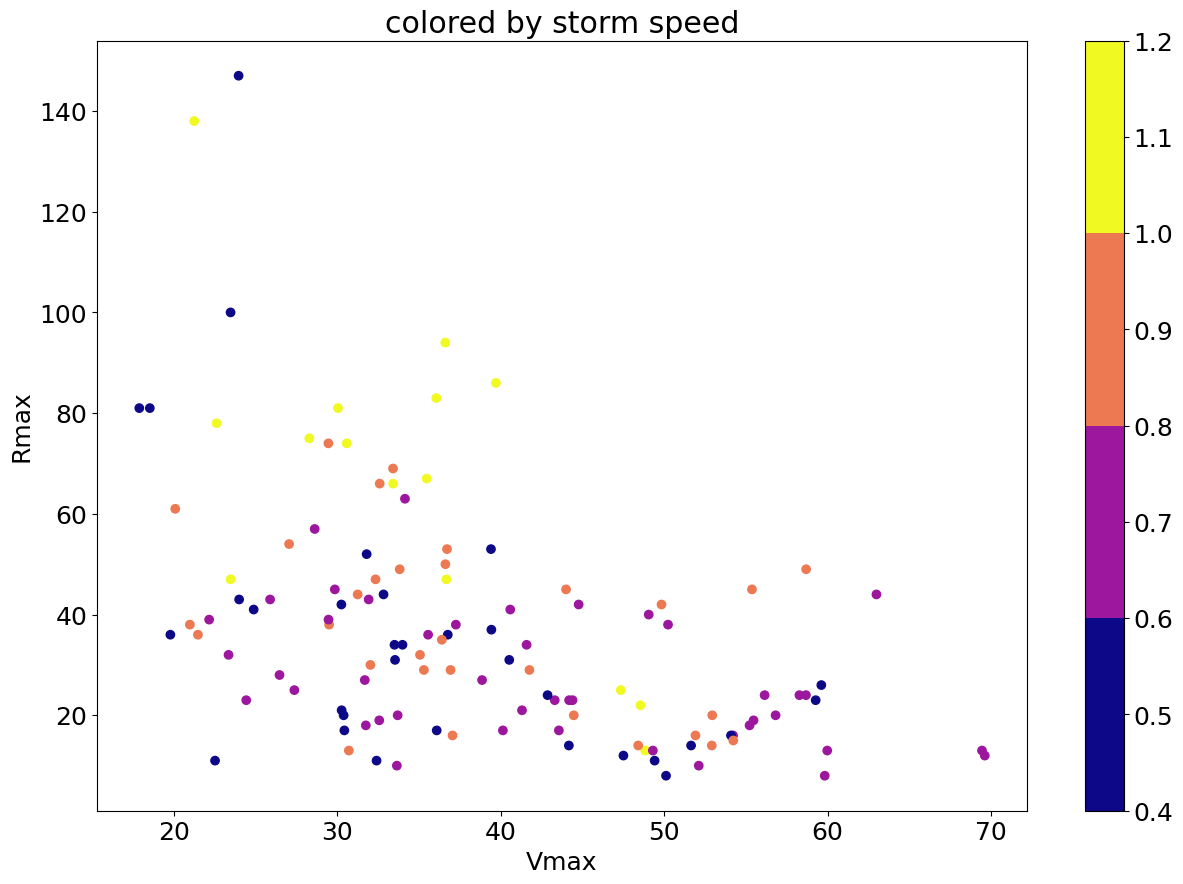

In [31]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d3.Vmax_1D, d3.Rmax_1D, c=d3.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

Text(0.5, 1.0, 'colored by storm speed')

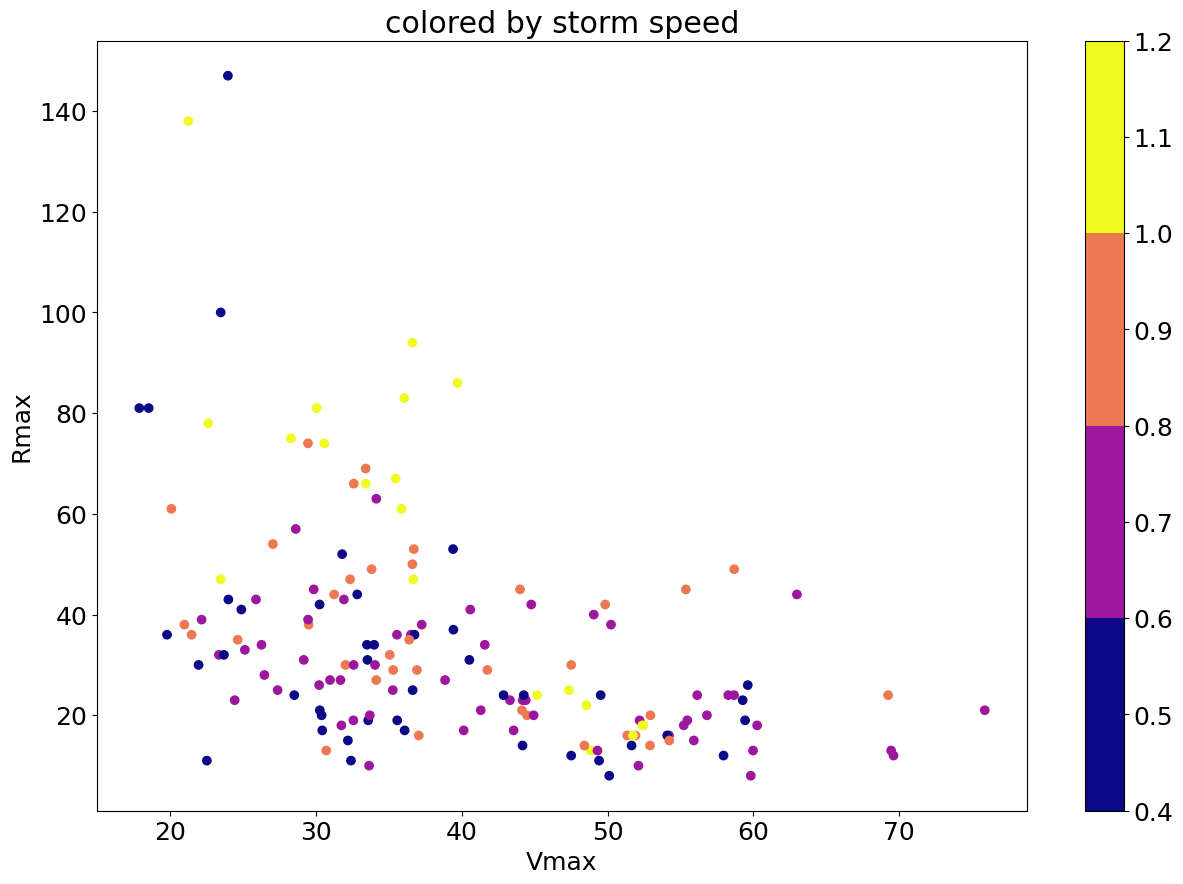

In [32]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

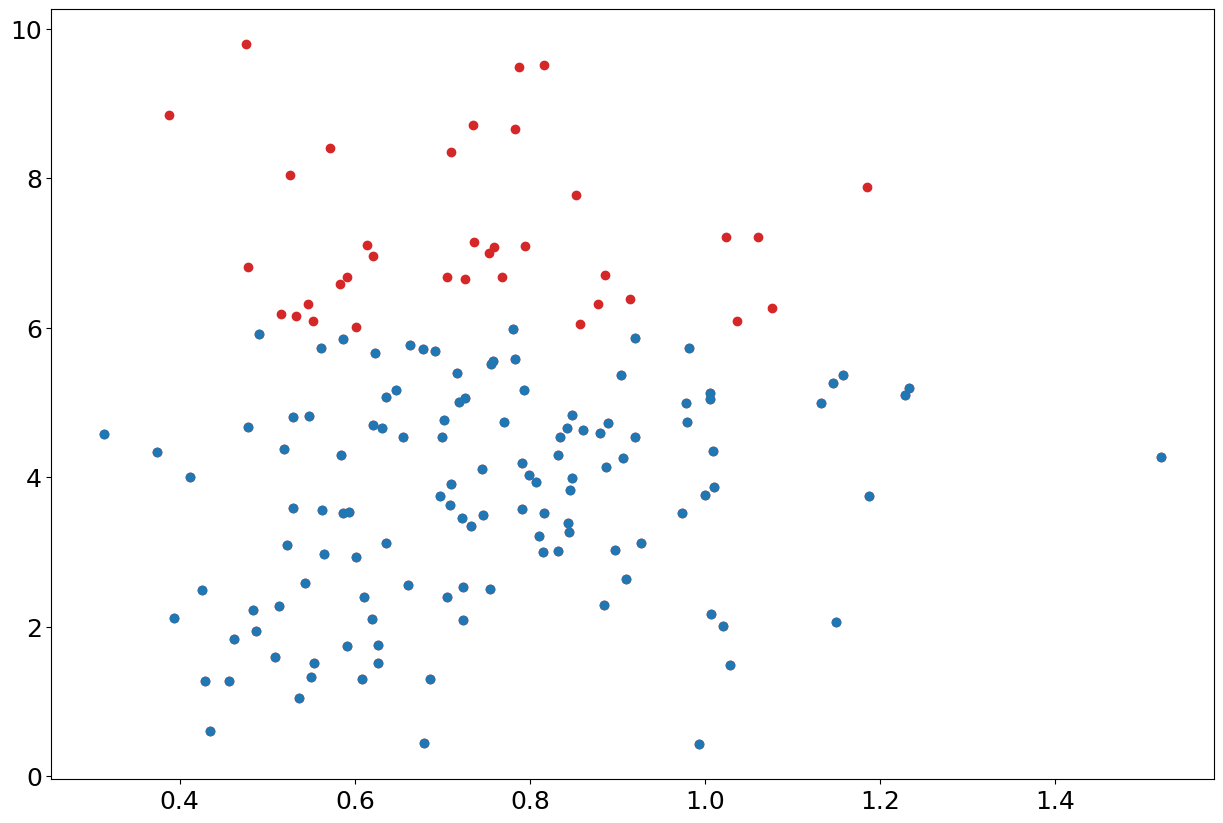

In [33]:
plt.scatter(d2.x_rkn, d2.cyclone_speed, color='tab:red')
plt.scatter(d3.x_rkn, d3.cyclone_speed, color='tab:blue')